# DQN

### 패키지 import
의존성 있는 패키지인 ``` numpy ```, ``` tensorflow ```, ``` keras ```를 import해야 한다.  
  
참고: keras는 단독으로 import하지 않고 반드시 ``` import tensorflow.keras as keras ```와 같이 ``` tensorflow ```를 통해 import해야 잠재적인 오류를 예방할 수 있다.  

주어진 모듈을 설치하기 위해서는 `pip install numpy`, `pip install tensorflow`를 실행하자.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

### ReplayBuffer 클래스
Replay buffer란 이전의 (S, a, S', R) 순서쌍들을 모아 둔 거대한 테이블을 뜻한다. 강화학습 특성상 환경과 상호작용하기에 시간 순서대로 데이터가 생성되는 즉시 학습시키면 bias가 발생하기 쉽다. 이러한 buffer를 도입함으로써 문제를 해결할 수 있다.  
 
이 class는 다음과 같은 method로 구성된다.
* 생성자
  * ```replay_size``` 변수에 최대 버퍼크기 명시
  * ```input_dims```에 state feature의 dimension 명시
* ```store```을 통해 S, a, S', R 값과 terminate 여부를 저장
* ```sample```을 통해 주어진 개수만큼 random sampling

In [2]:
class ReplayBuffer:
    def __init__(self, replay_size, input_dims):
        self.replay_size = replay_size
        self.mem_counter = 0
        
        self.state = np.zeros((self.replay_size, *input_dims), dtype=np.float32)
        self.next_state = np.zeros((self.replay_size, *input_dims), dtype=np.float32)
        self.action = np.zeros(self.replay_size, dtype=np.int32)
        self.reward = np.zeros(self.replay_size, dtype=np.float32)
        self.terminate = np.zeros(self.replay_size, dtype=np.int32)
    
    def store(self, state, action, reward, next_state, terminate):
        ''' ReplayBuffer에 단일 데이터쌍 저장 '''
        index = self.mem_counter % self.replay_size

        self.state[index]       = state
        self.next_state[index]  = next_state
        self.action[index]      = action
        self.reward[index]      = reward
        self.terminate[index]   = 1 - int(terminate)

        self.mem_counter += 1

    def sample(self, batch_size):
        ''' ReplayBuffer에서 batch_size만큼 임의의 데이터 샘플링 '''

        # 아직 replay buffer가 다 차지 않은 경우를 고려해 실제 space_size를 min함수를 이용해 산정
        space_size = min(self.mem_counter, self.replay_size)
        batch = np.random.choice(space_size, batch_size, replace=False)

        state       = self.state[batch]
        next_state  = self.next_state[batch]
        action      = self.action[batch]
        reward      = self.reward[batch]
        terminate   = self.terminate[batch]

        return state, action, reward, next_state, terminate

### ANN 모델 만들기
DQN에서 Tabular action을 나타내는 model을 tensorflow를 통해 컴파일한다.
* ``` l_rate ```는 학습률을 나타낸다.
* ``` n_actions ```는 tabular action의 개수를 나타낸다.
* ``` input_dims ```는 state의 feature dimension이다.

In [3]:
def build_dqn(l_rate, n_actions, input_dims):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_dims),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(n_actions, activation=None)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=l_rate), loss='mse')

    return model

아래는 간단한 ANN Model을 만드는 예제이다.

In [4]:
simple_ANN_model = build_dqn(1e-8, 100, (4,))

### DQN Agent 만들기
Agent는 위에서 만들어진 ` ReplayBuffer `와 ` build_dqn `을 함께 사용해 실제로 RL을 실행하는 클래스이다.
* 생성자
  * ` input_dims `는 입력 데이터의 차원이다.
  * ` l_rate `는 학습률 $\alpha$이다.
  * ` gamma `는 미래할인률 $\gamma$이다.
  * ` n_actions `는 사용 가능한 action 수이다.
  * ` batch_size `는 `ReplayBuffer`에서 한 번에 학습할 데이터 batch의 수이다.
  * ` epsilon_start `, `epsilon_decay`, `epsilon_end`는 $\epsilon$의 값을 통제한다. `start`에서 시작해 action을 선택할 때마다 `decay`만큼 깎이되, `end`보다 낮아지지 않는다.
  * ` replay_size `는 `ReplayBuffer`의 크기를 결정한다.
  * ` filename `은 모델을 저장할 파일의 이름이다.

In [5]:
class DQNAgent:
    def __init__(self, input_dims, l_rate, gamma, n_actions, batch_size,
        epsilon_start, epsilon_decay, epsilon_end,
        replay_size, filename):

        self.read_only = False

        self.gamma = gamma
        self.action = [i for i in range(n_actions)]
        self.batch_size = batch_size
        
        self.eps = epsilon_start
        self.eps_decay = epsilon_decay
        self.eps_end = epsilon_end

        self.memory = ReplayBuffer(replay_size, input_dims)
        self.Q = build_dqn(l_rate, n_actions, input_dims)

        self.filename = filename

    def store(self, state, action, reward, next_state, terminate):
        ''' internal ReplayBuffer에 상태 저장 '''
        if self.read_only:
            raise Exception("DQNDeploy class can only use model, not store.")
            return
        self.memory.store(state, action, reward, next_state, terminate)

    def choose_action(self, obs):
        ''' observation `obs`를 토대로 epsilon-greddy를 따르는 action 결정 '''
        if np.random.random() < self.eps:
            # epsilon하게 exploration
            action = np.random.choice(self.action)
        else:
            # argmax Q 선택
            state = np.array([obs])
            action_set = self.Q.predict(state)
            action = np.argmax(action_set)
        
        return action

    def learn(self):
        ''' 쌓아 둔 데이터로 random batch한 뒤 강화학습 진행 '''
        if self.read_only:
            raise Exception("DQNDeploy class can only use model, not learn.")
            return

        if self.memory.mem_counter < self.batch_size:
            return

        # n x input, n x 1, n x 1, n x input, n x 1
        states, actions, rewards, next_states, terminates = \
            self.memory.sample(self.batch_size)

        # n x n
        q_this = self.Q.predict(states)
        q_next = self.Q.predict(next_states)

        q_target = np.copy(q_this)
        enum_list = np.arange(self.batch_size, dtype=np.int32)

        # 과거 시행되었던 state-action pair에 대하여 bellman equation 업데이트
        q_target[enum_list, actions.astype(np.int32)] = rewards + \
            self.gamma * np.max(q_next, axis=1) * terminates

        # n x input ~ n x 1 에 대해 train on batch
        self.Q.train_on_batch(states, q_target)
        
        # epsilon decay
        if self.eps > self.eps_end:
            self.eps -= self.eps_decay
            
    def save_model(self):
        if self.read_only:
            raise Exception("DQNDeploy class can only use model, not save.")
            return

        self.Q.save(self.filename)
    
    def load_model(self):
        self.Q = keras.models.load_model(self.filename)

class DQNDeploy(DQNAgent):
    ''' Model의 학습과 저장은 불가능하고 오직 사용만을 위한 class '''
    def __init__(self, filename):
        self.filename = filename
        self.eps = 0
        self.read_only = True
        self.load_model()

## Model Evaluating

### Gym을 사용한 가상환경 준비
OpenAI에서 제공하는 gym 모듈을 사용해 보자. 이 모듈은 `pip install gym`을 통해 설치할 수 있다.

In [6]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm

env = gym.make('CartPole-v1')
observation = env.reset()

이 상황에서 `DQNAgent`를 도입해 문제를 해결해 보자. 이때 observation은 `env.observation_space.shape`의 dimensionality를, action은 `env.action_space.n`의 dimensionality를 가진다. 

In [7]:
print(env.observation_space.shape)
print(env.action_space.n)

(4,)
2


### Agent 학습
아래의 코드 블록을 실행하면 랜덤하게 초기화된 cartAgent가 강화학습을 시작한다.

In [ ]:
cartAgent = DQNAgent(
    input_dims=env.observation_space.shape, 
    l_rate=0.001, 
    gamma=0.98,
    n_actions=env.action_space.n, 
    batch_size=64, 
    epsilon_start=1, 
    epsilon_decay=0.005,
    epsilon_end=0.01,
    replay_size=10000,
    filename='cartpole-dqn'
)

scores, scores_avg = list(), list()
prgress = tqdm(range(500))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartAgent.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)
        cartAgent.store(obs_this, action, reward, obs_next, done)

        # 보상 저장
        score += reward
        obs_this = obs_next
        # env.render() # 렉 걸릴 경우 제외
        
        # Agent 학습
        cartAgent.learn()

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:])) # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f} | epsilon {:>.2f}"
        .format(scores[-1], scores_avg[-1], cartAgent.eps))

    if episode % 50 == 0: # 50 episode마다 모델을 저장
        cartAgent.save_model()

plt.plot(np.arange(len(scores_avg)), np.array(scores_avg)) # 이동평균 점수 그래프 그리기

다음은 학습한 모델을 불러와 실행하는 블록이다.

score 500.0 | recent average score 394.0 | epsilon 0.00: 100%|██████████| 5/5 [01:17<00:00, 15.47s/it]


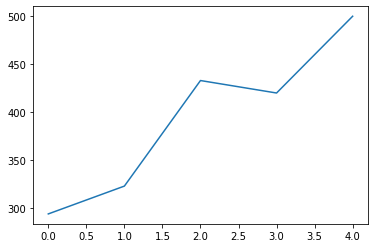

In [11]:
cartDeploy = DQNDeploy('cartpole-dqn')

scores, scores_avg = list(), list()
prgress = tqdm(range(5))

for episode in prgress:
    # 환경 및 점수 초기화
    score = 0
    obs_this = env.reset()
    done = False

    while not done:
        # Agent가 선택
        action = cartDeploy.choose_action(obs_this)
        obs_next, reward, done, info = env.step(action)

        # 보상 저장
        score += reward
        obs_this = obs_next
        env.render() # 렉 걸릴 경우 제외

    scores.append(score) # 점수 기록
    scores_avg.append(np.mean(scores[-30:])) # 이동평균 산출
    prgress.set_description("score {:>3.1f} | recent average score {:>3.1f} | epsilon {:>.2f}"
        .format(scores[-1], scores_avg[-1], cartDeploy.eps))

plt.plot(np.arange(len(scores)), np.array(scores)) # 이동평균 점수 그래프 그리기